In [221]:
#!python -m spacy download en_core_web_lg

In [268]:
import numpy as np
import pandas as pd
import selenium as se
import seaborn as sns
import spacy
import openpyxl
import nltk
import ssl
import re
import sklearn
import gensim
import en_core_web_lg

from bs4 import BeautifulSoup as bs
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from nltk.corpus import words

# NLP stuff
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel
from spacy.pipeline import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS

from tqdm import tqdm_notebook as tqdm
from pprint import pprint

In [3]:
df_big_easy = pd.read_excel('Reviews.xlsx')
df_big_easy.head()

,author,reviewBody,reviewRating,ratingMaxvalue,reviewTags,dateCreated,images,reviewUrl,reviewSource,orginalText,name,reviewCount,aggregateRating,address,place_id,input,businessUrl
0,Aaron Gregory,"Our server Marco, was on point with covid guid...",3.0,5.0,NaN,2 months ago,NaN,https://www.google.com/maps/contrib/1087222116...,www.google.com,NaN,Big Easy Canary Wharf,"3,516",3.9,"Crossrail Pl, London, United Kingdom",ChIJj5YwFrcCdkgRZ7QcD-FJ2Zo,https://www.google.com/maps/place/Big+Easy+Can...,https://www.google.com/maps/place/?q=place_id:...
1,Clement Escaffre,Counter reservations apparently don't give you...,1.0,5.0,NaN,a year ago,NaN,https://www.google.com/maps/contrib/1087579170...,www.google.com,NaN,Big Easy Canary Wharf,"3,516",3.9,"Crossrail Pl, London, United Kingdom",ChIJj5YwFrcCdkgRZ7QcD-FJ2Zo,https://www.google.com/maps/place/Big+Easy+Can...,https://www.google.com/maps/place/?q=place_id:...
2,Amanjot Klair,Good food. But there is a foul smell that find...,4.0,5.0,NaN,a year ago,NaN,https://www.google.com/maps/contrib/1014737661...,www.google.com,NaN,Big Easy Canary Wharf,"3,516",3.9,"Crossrail Pl, London, United Kingdom",ChIJj5YwFrcCdkgRZ7QcD-FJ2Zo,https://www.google.com/maps/place/Big+Easy+Can...,https://www.google.com/maps/place/?q=place_id:...
3,Deividas Petrauskas,NaN,4.0,5.0,NaN,a year ago,NaN,https://www.google.com/maps/contrib/1157723729...,www.google.com,NaN,Big Easy Canary Wharf,"3,516",3.9,"Crossrail Pl, London, United Kingdom",ChIJj5YwFrcCdkgRZ7QcD-FJ2Zo,https://www.google.com/maps/place/Big+Easy+Can...,https://www.google.com/maps/place/?q=place_id:...
4,Hiro,British pub with amazing line of draft beers -...,5.0,5.0,NaN,a year ago,NaN,https://www.google.com/maps/contrib/1141368057...,www.google.com,NaN,Big Easy Canary Wharf,"3,516",3.9,"Crossrail Pl, London, United Kingdom",ChIJj5YwFrcCdkgRZ7QcD-FJ2Zo,https://www.google.com/maps/place/Big+Easy+Can...,https://www.google.com/maps/place/?q=place_id:...


In [4]:
df_big_easy.shape

(1000, 17)

### Keep interesting columns, remove rows with review missing

In [309]:
df_big_easy_simple = df_big_easy[['reviewBody', 'reviewRating', 'dateCreated']].copy(deep=True)
df_big_easy_simple = df_big_easy_simple.dropna(subset=['reviewBody'])
print(df_big_easy_simple.shape)
df_big_easy_simple.head()

(621, 3)


,reviewBody,reviewRating,dateCreated
0,"Our server Marco, was on point with covid guid...",3.0,2 months ago
1,Counter reservations apparently don't give you...,1.0,a year ago
2,Good food. But there is a foul smell that find...,4.0,a year ago
4,British pub with amazing line of draft beers -...,5.0,a year ago
6,"Waited for 15m to get served at the bar, wasti...",1.0,a year ago


### Date cleaning

Turn '1 week ago', '6 hours ago' etc. into dates

In [6]:
# Turn strings into dates
def clean_date(string_date):
    curr_date = datetime.now()
    split_date = string_date.split(' ')

    n = split_date[0]
    n = 1 if n in ('a', 'an') else int(n) # Replace 'a week ago' / 'an hour ago' with '1 week ago'
    
    delta = split_date[1]
    
    # Check assumption that any n>1 must be plural
    assert (n==1) or (n>1 and delta[-1]=='s')
    
    # Stip trailing 's' from delta
    if n>1:
        delta = delta[:-1]

    if delta == 'year':
        return curr_date - timedelta(days=365*n)
    elif delta == 'month':
        return curr_date - timedelta(days=30*n)
    elif delta == 'week':
        return curr_date - timedelta(weeks=n)
    elif delta == 'day':
        return curr_date - timedelta(days=n)
    elif delta == 'hour':
        return curr_date - timedelta(hours=n)
    elif delta == 'minute':
        return curr_date - timedelta(minutes=n)
    elif delta == 'moment':
        return curr_date - timedelta(seconds=n)
    else:
        raise ValueError(f'Unhandled delta type {delta}')

In [310]:
df_big_easy_simple['date_clean'] = df_big_easy_simple['dateCreated'].apply(lambda d: clean_date(d)).astype('datetime64[D]')
df_big_easy_simple.head()

,reviewBody,reviewRating,dateCreated,date_clean
0,"Our server Marco, was on point with covid guid...",3.0,2 months ago,2021-06-05
1,Counter reservations apparently don't give you...,1.0,a year ago,2020-08-04
2,Good food. But there is a foul smell that find...,4.0,a year ago,2020-08-04
4,British pub with amazing line of draft beers -...,5.0,a year ago,2020-08-04
6,"Waited for 15m to get served at the bar, wasti...",1.0,a year ago,2020-08-04


### Language cleaning

Only keep English reviews (run the below if you need to download corpus).

In [15]:
# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# nltk.download()

In [317]:
df_big_easy_eng = df_big_easy_simple.copy(deep=True)

# Get list of English words
eng_words = words.words('en')
eng_words_lower = [w.lower() for w in eng_words]

# Assume any review where > 50% of first 10 words are in English corpus, is an English review
def pct_review_words_in_eng_corpus(text):
    
    # Keep characters and spaces
    text_alpha = re.sub(r'[^A-z ]', '', text) 
    
    # Only take first 10 tokens
    tokens = text_alpha.split(' ')[:10]
    n_tokens = len(tokens)
    tokens_in_eng_corpus = np.sum([1 if t in eng_words_lower else 0 for t in tokens])
    
    return float(tokens_in_eng_corpus)/n_tokens


# Apply function
df_big_easy_eng['is_english'] = df_big_easy_eng.apply(lambda row: pct_review_words_in_eng_corpus(row['reviewBody'].lower()) >= 0.5,
                                                      axis=1)

# Drop rows that aren't in English
df_big_easy_eng = df_big_easy_eng[df_big_easy_eng['is_english']==True].drop(['is_english'], axis=1)
print(f'{str(df_big_easy_simple.shape[0]-df_big_easy_eng.shape[0])} non-English rows dropped')

7 non-English rows dropped


### Further text cleaning

In [390]:
pos_tags = ['a','s','r','n','v']

for p in pos_tags:
    print(' '.join([wnl.lemmatize(t, pos=p) for t in 'My understandable doing sentences looked like this. Bit great'.lower().split()]))

my understandable doing sentences looked like this. bit great
my understandable doing sentences looked like this. bit great
my understandable doing sentences looked like this. bit great
my understandable doing sentence looked like this. bit great
my understandable do sentence look like this. bite great


In [320]:
from nltk.corpus import stopwords
# nltk.download('stopwords')
sw = stopwords.words('english')

df_big_easy_clean = df_big_easy_eng.copy(deep=True)


def clean_text(text):
    
    tokens = text.split(' ')
    
    # Get lower case
    tokens_lower = [t.lower() for t in tokens]
    
    # Then remove stopwords
    tokens_no_sw = [t for t in tokens_lower if t not in sw]
    
    # Then strip punctuation
    tokens_alpha = [re.sub('[^A-z]', '', t) for t in tokens_no_sw]
    
    # Then take lemmas
    lemmas = [wnl.lemmatize(t, pos='v') for t in tokens_alpha]
    
    # Rejoin as single string
    text_clean = ' '.join(lemmas)
    
    # Handle duplicate spaces
    return re.sub(r'(\s)+', ' ', text_clean)
    

df_big_easy_clean['review_clean'] = df_big_easy_clean.apply(lambda row: clean_text(row['reviewBody']),
                                                            axis=1)

df_big_easy_clean.head()

,reviewBody,reviewRating,dateCreated,date_clean,review_clean
0,"Our server Marco, was on point with covid guid...",3.0,2 months ago,2021-06-05,server marco point covid guide line service ge...
1,Counter reservations apparently don't give you...,1.0,a year ago,2020-08-04,counter reservations apparently give table acc...
2,Good food. But there is a foul smell that find...,4.0,a year ago,2020-08-04,good food foul smell find every time time ever...
4,British pub with amazing line of draft beers -...,5.0,a year ago,2020-08-04,british pub amaze line draft beers truffel chi...
6,"Waited for 15m to get served at the bar, wasti...",1.0,a year ago,2020-08-04,wait m get serve bar waste sizeable chunk lunc...


# NLP stuff

### Basic analysis

<AxesSubplot:xlabel='reviewRating', ylabel='count'>

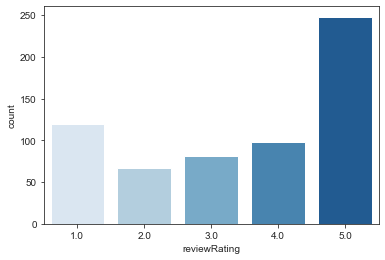

In [321]:
sns.countplot(data=df_big_easy_eng,
              x='reviewRating',
              palette='Blues')

Look over time

In [322]:
df_monthly = df_big_easy_eng.set_index('date_clean').resample('M')['reviewRating'].agg(('mean','count'))
df_monthly #= df_monthly.query('')

,mean,count
date_clean,,
2020-08-31,3.581395,301
2020-09-30,4.000000,2
2020-10-31,4.222222,9
2020-11-30,3.755102,49
2020-12-31,3.304348,23
2021-01-31,3.400000,20
2021-02-28,5.000000,2
2021-03-31,2.333333,3
2021-04-30,5.000000,1


(187, 5)
(179, 5)
(248, 5)


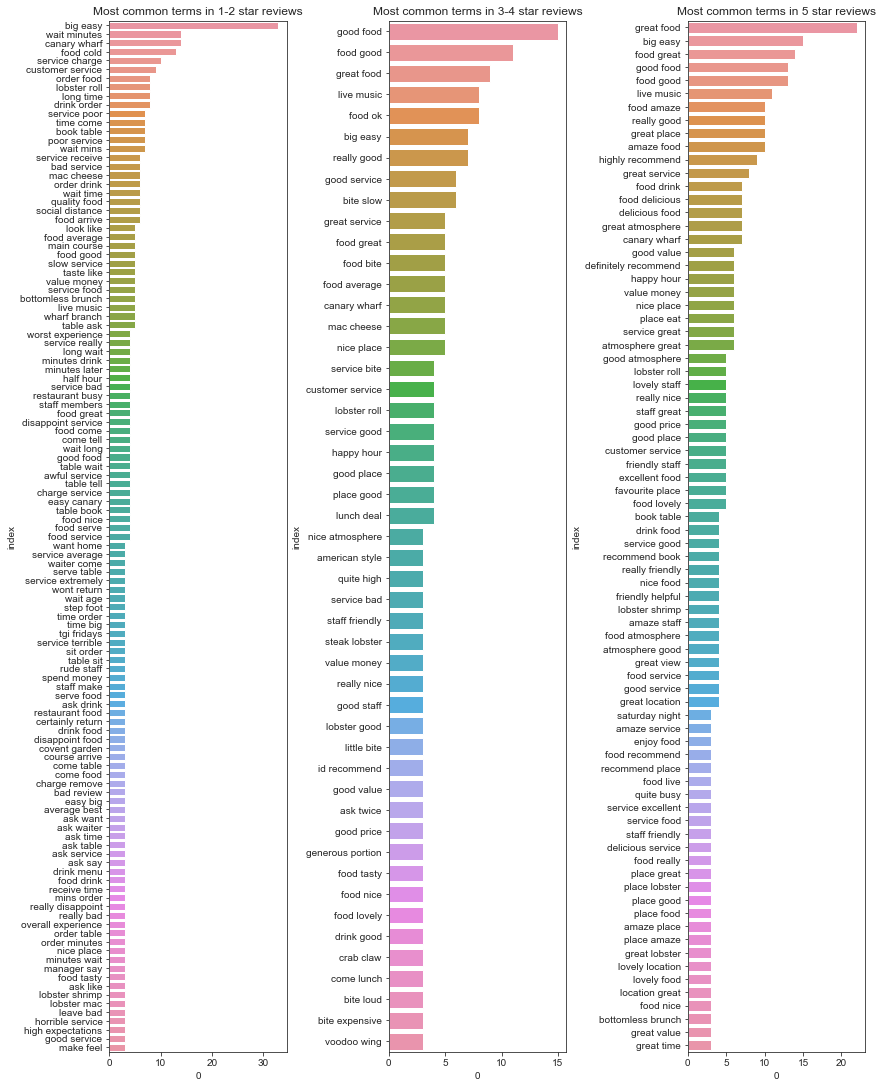

In [324]:
from sklearn.feature_extraction.text import CountVectorizer

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,15),
                        constrained_layout=True)

# Bucket reviews into 1-2 stars, 3-4 stars, and 5 stars
review_buckets = {0: [1, 2], 
                  1: [3, 4], 
                  2: [5, 5]}

for i in range(3):
    
    # Get review bucket
    rev_min, rev_max = review_buckets[i]
    
    # Filter for certain reviews
    df_filt = df_big_easy_clean.query(f'reviewRating>={rev_min} and reviewRating<={rev_max}')
    print(df_filt.shape)
    
    # Set up vectorizer
    C = CountVectorizer(ngram_range=(2,2),
                        max_df=1.0,
                        min_df=3,
                        stop_words='english')
    
    # Get counts
    res = C.fit_transform(df_filt['review_clean'])
    
    # Set up dataframe
    df_res = pd.DataFrame(data=res.todense(),
                          columns=C.get_feature_names())
    

    # Turn into plottable format
    df_plot = df_res.T.apply(lambda row: np.sum(row), axis=1).sort_values(ascending=False).reset_index()
    
    # Plot
    sns.barplot(data=df_plot,
                # When you use reset_index() on a series, you end up with index and 0 as column names
                x=0,
                y='index',
                ax=axs[i])
    
    if rev_min == rev_max:
        title_stars = f'{rev_min} star'
    else:
        title_stars = f'{rev_min}-{rev_max} star'
    
    axs[i].set_title(f'Most common terms in {title_stars} reviews')

### Entity recognition

Get english language and test parsing on one example

In [79]:
nlp = spacy.load("en_core_web_lg")

In [340]:
row = 64
doc = nlp(df_big_easy_eng.reset_index()['reviewBody'][row])

print(doc[:20], df_big_easy_eng.reset_index()['reviewRating'][row], sep='\n')

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_, spacy.explain(token.dep_),
            token.shape_, token.is_alpha, token.is_stop, sep=', ')

Poor service and extremely poor value for money. I had a portion of ribs as my main witch cost
1.0
Poor, poor, ADJ, JJ, amod, adjectival modifier, Xxxx, True, False
service, service, NOUN, NN, ROOT, None, xxxx, True, False
and, and, CCONJ, CC, cc, coordinating conjunction, xxx, True, True
extremely, extremely, ADV, RB, advmod, adverbial modifier, xxxx, True, False
poor, poor, ADJ, JJ, amod, adjectival modifier, xxxx, True, False
value, value, NOUN, NN, conj, conjunct, xxxx, True, False
for, for, ADP, IN, prep, prepositional modifier, xxx, True, True
money, money, NOUN, NN, pobj, object of preposition, xxxx, True, False
., ., PUNCT, ., punct, punctuation, ., False, False
I, I, PRON, PRP, nsubj, nominal subject, X, True, True
had, have, VERB, VBD, ROOT, None, xxx, True, True
a, a, DET, DT, det, determiner, x, True, True
portion, portion, NOUN, NN, dobj, direct object, xxxx, True, False
of, of, ADP, IN, prep, prepositional modifier, xx, True, True
ribs, rib, NOUN, NNS, pobj, object of pre

Visualise dependencies

In [343]:
spacy.displacy.render(doc,
                      options={'compact':True})

In [346]:
spacy.displacy.render(doc, style='ent', jupyter=True)

Go one step further, and label data with dependencies

In [345]:
# Document is list of sentences, .sents is a generator object that allows us to grab these
sentences = list(doc.sents)

# Get function to extract information from sentences
def get_dependency_data(sentence):
    for word in sentence:
        output_prelim = f'{word} has '
        dep = word.dep_
        dep_first_letter = dep[0] if dep is not None else None

        if spacy.explain(dep) is not None:
            suffix = f'label {dep} ({spacy.explain(dep)})'
        else:
            suffix = f'label {dep}'
        
        print(output_prelim + suffix)
        

for s in sentences:
    get_dependency_data(s)
    print('---------------\n')
        
        

Poor has label amod (adjectival modifier)
service has label ROOT
and has label cc (coordinating conjunction)
extremely has label advmod (adverbial modifier)
poor has label amod (adjectival modifier)
value has label conj (conjunct)
for has label prep (prepositional modifier)
money has label pobj (object of preposition)
. has label punct (punctuation)
---------------

I has label nsubj (nominal subject)
had has label ROOT
a has label det (determiner)
portion has label dobj (direct object)
of has label prep (prepositional modifier)
ribs has label pobj (object of preposition)
as has label mark (marker)
my has label poss (possession modifier)
main has label amod (adjectival modifier)
witch has label nsubj (nominal subject)
cost has label advcl (adverbial clause modifier)
£ has label nmod (modifier of nominal)
20 has label dobj (direct object)
and has label cc (coordinating conjunction)
consisted has label conj (conjunct)
of has label prep (prepositional modifier)
2 has label pobj (object of

### LDA

Get counts for all 1-2 grams in reviews

In [347]:
C = CountVectorizer(ngram_range=(1,2),
                    max_df=1.0,
                    min_df=3,
                    stop_words='english')
    
# Get counts
res = C.fit_transform(df_big_easy_clean['review_clean'])

# To dataframe
df_res = pd.DataFrame(data=res.todense(),
                          columns=C.get_feature_names())

df_res.head()

,able,absolute,absolutely,absolutely delicious,accept,accommodate,acknowledge,actually,add,advance,...,worst experience,worth,worth visit,wouldnt,write,wrong,years,years ago,yes,yummy
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [348]:
# For topic analysis, remove very common terms that appear in every topic
reviews_less_stopwords = df_big_easy_clean['review_clean'].apply(lambda review: re.sub(r'(food)', '', review))

list_of_list_of_tokens = [rev.split() for rev in reviews_less_stopwords]
dictionary_LDA = corpora.Dictionary(list_of_list_of_tokens)
corpus = [dictionary_LDA.doc2bow(list_of_tokens) for list_of_tokens in list_of_list_of_tokens]

In [369]:
num_topics = 20
lda_model = LdaModel(corpus, 
                     num_topics=num_topics, 
                     id2word=dictionary_LDA, 
                     passes=3,
                     alpha=[0.01]*num_topics,
                     eta=[0.01]*len(dictionary_LDA.keys()))

In [370]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(i)+": "+ topic)
    print()

0: 0.017*"great" + 0.016*"get" + 0.015*"service" + 0.013*"give" + 0.012*"staff" + 0.010*"good" + 0.010*"rib" + 0.009*"go" + 0.009*"its" + 0.008*"disappoint"

1: 0.032*"good" + 0.018*"service" + 0.018*"place" + 0.016*"great" + 0.015*"come" + 0.015*"go" + 0.013*"time" + 0.012*"restaurant" + 0.010*"it" + 0.009*"would"

2: 0.033*"great" + 0.028*"view" + 0.024*"staff" + 0.024*"good" + 0.024*"lovely" + 0.018*"excellent" + 0.018*"place" + 0.017*"really" + 0.017*"atmosphere" + 0.016*"back"

3: 0.022*"service" + 0.017*"nice" + 0.015*"table" + 0.015*"really" + 0.014*"go" + 0.014*"place" + 0.013*"us" + 0.013*"would" + 0.012*"restaurant" + 0.009*"friends"

4: 0.018*"table" + 0.016*"service" + 0.015*"good" + 0.014*"ask" + 0.014*"place" + 0.013*"order" + 0.012*"staff" + 0.012*"time" + 0.012*"come" + 0.011*"go"

5: 0.016*"lobster" + 0.015*"order" + 0.013*"come" + 0.013*"place" + 0.011*"good" + 0.010*"amaze" + 0.010*"go" + 0.009*"us" + 0.009*"also" + 0.009*"get"

6: 0.026*"us" + 0.018*"disappoint" + 0

Get sentiment against each topic

In [374]:
df_big_easy_clean_r = df_big_easy_clean.reset_index(drop=True)

sentiment_by_topic = []

# For each corpus, get rating
for idx, row in df_big_easy_clean_r.iterrows():
    
    # Get topics relevant to that row. This returns list of tuples, where first tuple is first topic, and first item in tuple is the topic id
    topic = lda_model[corpus[idx]][0][0]
    
    # Get sentiment
    sentiment = row['reviewRating']
    
    if topic == 4:
        print(sentiment, idx, row['reviewBody'][:120], sep=' ** ')
    
    # Append for first topic tagged
    sentiment_by_topic.append([sentiment, topic])

3.0 ** 6 ** Firstly, we had to queue for ages to be seated as there was only 1 member of staff checking reservations, taking tempera
2.0 ** 23 ** BAD service, “okay” food, love their milkshakes tho.
2.0 ** 38 ** The food was average at best (full of oil, greasy and small portions), but could have been 3/3.5 stars if it wasn’t for 
1.0 ** 52 ** My partner had booked the restaurant for my 27th birthday as a surprise, we were very excited. On arrival, the reception
2.0 ** 59 ** Good food, rude and inattentive staff, won't return.
2.0 ** 125 ** Food was really good as usual. However service was not on point at all. We had to move seats as there was something grea
2.0 ** 126 ** Was surprisingly disappointed. Been to the covent garden store before and was very happy with the whole experience. This
5.0 ** 131 ** Very very loud music. Not very nice when your trying to eat. However the chips here are out of this world and that’s the
1.0 ** 135 ** Arrived for our table that was booked for 9pm, n

7     68
9     65
3     48
4     43
2     38
15    37
19    34
1     33
11    31
16    26
12    24
5     23
17    22
8     22
0     19
18    19
10    17
14    17
13    15
6     13
Name: topic, dtype: int64


<AxesSubplot:xlabel='rating', ylabel='topic'>

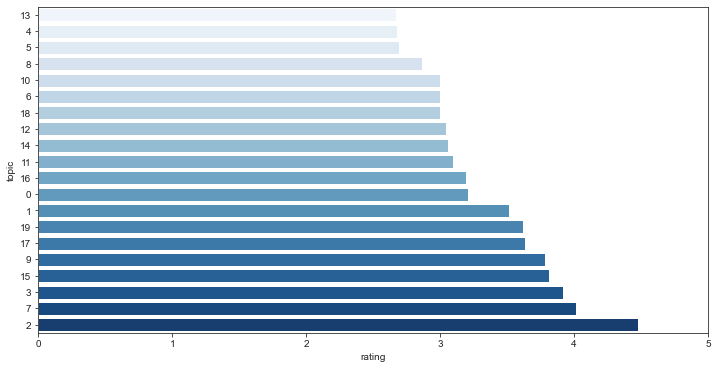

In [372]:
df_sentiment_by_topic = pd.DataFrame(data=sentiment_by_topic,
                                     columns=['rating', 'topic'])

df_sentiment_by_topic['topic'] = df_sentiment_by_topic['topic'].astype(str)

print(df_sentiment_by_topic['topic'].value_counts())


plt.figure(figsize=(12,6))
plt.xlim((0,5))

# Collapse
sns.barplot(data=df_sentiment_by_topic.groupby('topic')['rating'].mean().reset_index().sort_values(by='rating'),
              y='topic',
              x='rating',
            palette='Blues')

In [354]:
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim_models
vis = pyLDAvis.gensim_models.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

/Users/jackcook/PycharmProjects/reviews-tool/venv/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


/Users/jackcook/PycharmProjects/reviews-tool/venv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jackcook/PycharmProjects/reviews-tool/venv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jackcook/PycharmProjects/reviews-tool/venv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jackcook/PycharmProjects/reviews-tool/venv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from im

# Outputs

**Q: How do my reviews look over time - are they getting worse or better?**

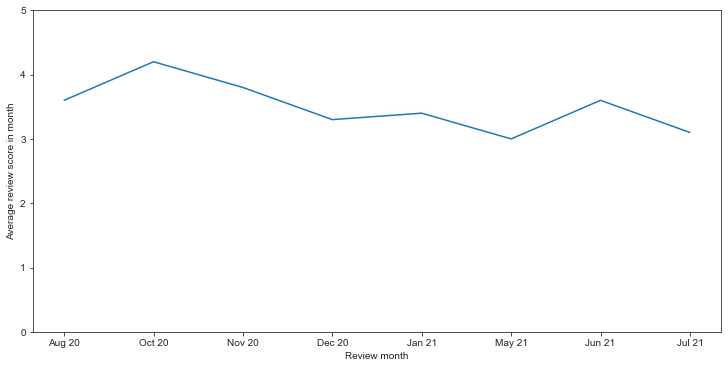

In [284]:
from datetime import datetime
sns.set_style('ticks')

# Group reviews by month
df_monthly_output = df_big_easy_eng.set_index('date_clean').resample('M')['reviewRating'].agg(('mean','count')).reset_index()

# Due to lockdown, some months have next to no reviews - set months with 5 or less reviews to score of 0
#df_monthly_output.loc[df_monthly_output['count'] < 5, 'mean'] = 0
df_monthly_output = df_monthly_output.query('count > 5')

# Convert datetime into date, and round 'mean' to 1 decimal place
df_monthly_output['date_clean'] = [d.strftime("%b %y") for d in df_monthly_output['date_clean']]
df_monthly_output['mean'] = df_monthly_output['mean'].map(lambda n: np.around(n, 1))

# Plot
plt.figure(figsize=(10,5), constrained_layout=True)
chart = sns.lineplot(data=df_monthly_output,
                     x='date_clean',
                     y='mean',
                     palette='Blues')
#chart.bar_label(chart.containers[0])
plt.xlabel('Review month')
plt.ylabel('Average review score in month')
plt.ylim(0,5)
plt.show()

In [383]:
df_filt2[['bite' in r.lower() for r in df_filt2['reviewBody']]]

,reviewBody,reviewRating,dateCreated,date_clean,review_clean


In [384]:
print(df_filt2['reviewBody'][176])

Nice & reasonable price for lobster if that is your thing. Bit slow on the service & Shrimp in batter could have more flavour... but still good!


(89, 5)
(55, 5)
(59, 5)


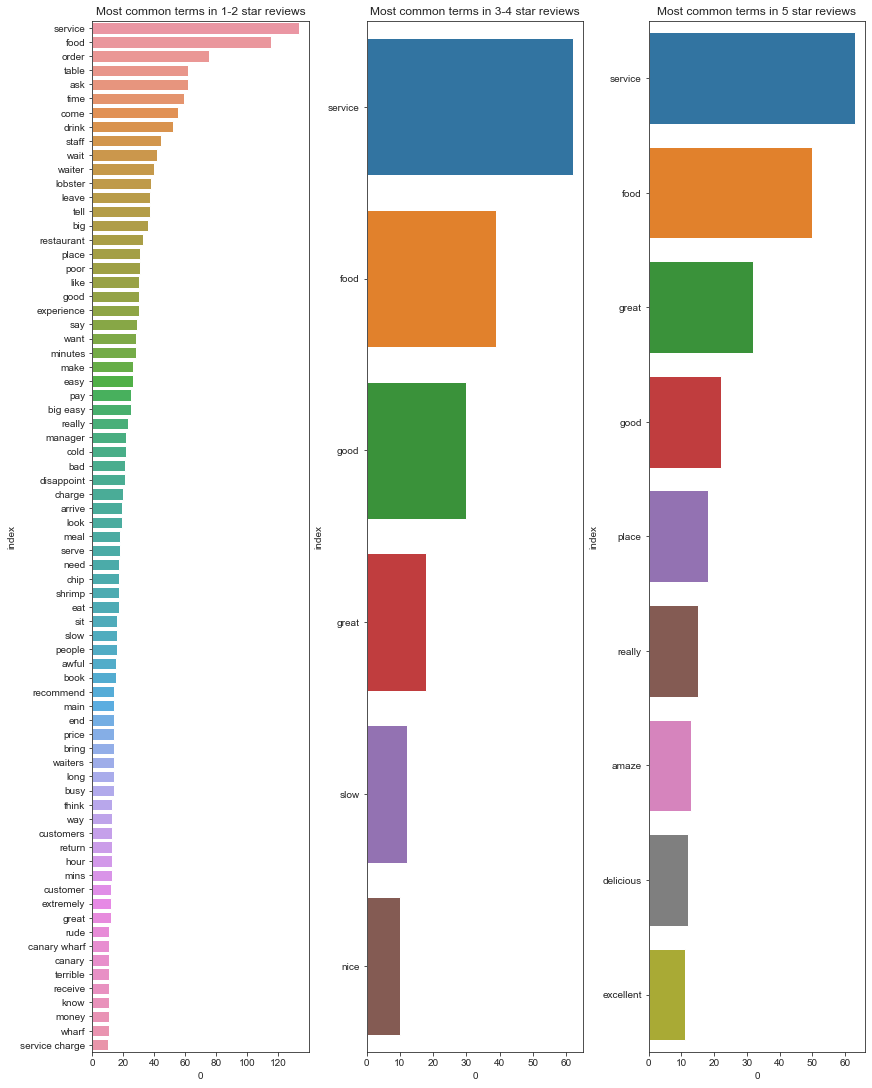

In [387]:
# Testing filtering for specific words

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,15),
                        constrained_layout=True)

# Bucket reviews into 1-2 stars, 3-4 stars, and 5 stars
review_buckets = {0: [1, 2], 
                  1: [3, 4], 
                  2: [5, 5]}

for i in range(3):
    
    # Get review bucket
    rev_min, rev_max = review_buckets[i]
    
    # Filter for certain reviews
    df_filt2 = df_big_easy_clean.query(f'reviewRating>={rev_min} and reviewRating<={rev_max}')
    
    # Then filter for a given word
    df_filt2 = df_filt2[['service' in r.lower() for r in df_filt2['reviewBody']]]
    print(df_filt2.shape)
    
    # Set up vectorizer
    C2 = CountVectorizer(ngram_range=(1,2),
                        max_df=1.0,
                        min_df=10,
                        stop_words='english')
    
    # Get counts
    res2 = C2.fit_transform(df_filt2['review_clean'])
    
    # Set up dataframe
    df_res2 = pd.DataFrame(data=res2.todense(),
                           columns=C2.get_feature_names())
    

    # Turn into plottable format
    df_plot2 = df_res2.T.apply(lambda row: np.sum(row), axis=1).sort_values(ascending=False).reset_index()
    
    # Plot
    sns.barplot(data=df_plot2,
                # When you use reset_index() on a series, you end up with index and 0 as column names
                x=0,
                y='index',
                ax=axs[i])
    
    if rev_min == rev_max:
        title_stars = f'{rev_min} star'
    else:
        title_stars = f'{rev_min}-{rev_max} star'
    
    axs[i].set_title(f'Most common terms in {title_stars} reviews')